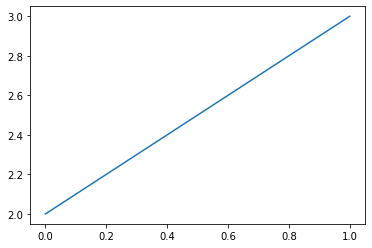

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import genpareto

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import trange, tqdm
#from anomaly_scoring import get_anomaly_scores

import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline 

import utils
from utils import read_machine_data
from utils import softclip
from utils import plot_train_test_reconstructions
import evaluation_utils
from models.cnn_sigmaVAE_flow import CNN_sigmaVAE_flow

from maf import MAF

plt.plot([0,1],[2,3])
plt.show()


In [4]:
window_size=32
batch_size=256
X_train_data, X_test_data, X_train_tensor, X_test_tensor, df_Y_test, trainloader, testloader = read_machine_data('../../datasets/ServerMachineDataset/machine-1-1', window_size, batch_size)
 

torch.Size([889, 1, 32, 38]) torch.Size([889, 1, 32, 38])


In [5]:
def train_flow_model(model, num_epochs, learning_rate, dataloader):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=num_epochs
    tq = tqdm(range(epochs))
    
    losses = []
    
    for epoch in tq:
        flag = False
        for j, data in enumerate(dataloader, 0):

            model.train()
            
            optimizer.zero_grad()

            #batches
            inputs, labels = data
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs.cpu()
            inputs.to(device)
            labels = labels.cuda() if torch.cuda.is_available() else labels.cpu()
            labels.to(device)

            outputs, rec_mu, rec_sigma, kl = model(inputs)

            rec_comps, rec, rec_mu_sigma_loss, kl = model.loss_function(outputs, labels, rec_mu, rec_sigma, kl)

            loss = rec + kl + rec_mu_sigma_loss

            if(np.isnan(loss.item())):
                print("Noped out at", epoch, j, kl, rec_comps)
                flag = True
                break

            loss.backward()
            optimizer.step()
        if(flag):
            break
        tq.set_postfix(loss=loss.item())
        #print(epoch, 'total :' + str(loss.item()) + ' rec : ' + str(rec.item()) + ' kl : ' + str(kl.sum().item()) + ' sigma: ' + str(model.log_sigma.item()))

        losses.append(loss)
        
        #break
        
    plt.plot(losses)
    plt.show()
    
    return model

CNN_sigmaVAE_flow(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 4, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc41): Linear(in_features=2080, out_features=8, bias=True)
  (fc42): Linear(in_features=2080, out_features=8, bias=True)
  (defc1): Linear(in_features=8, out_features=2080, bias=True)
  (deconv1): ConvTranspose2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (debn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
  (debn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2

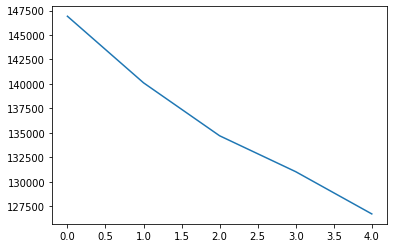

In [16]:
model = CNN_sigmaVAE_flow(latent_dim=8, window_size=window_size, flow_type='Planar')
model.to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()
print(model)

model = train_flow_model(model, 5, .005, trainloader)

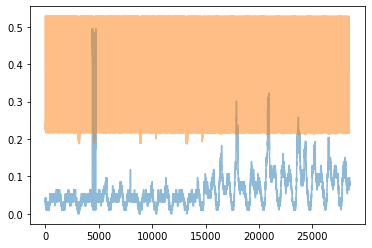

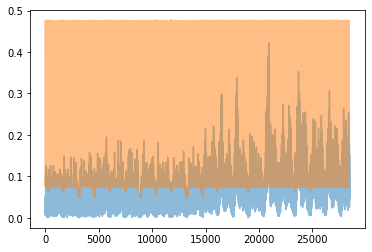

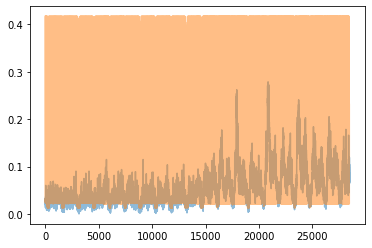

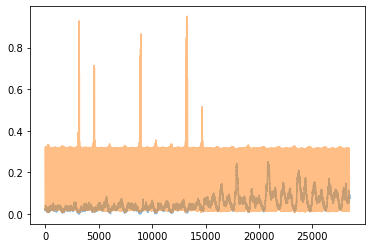

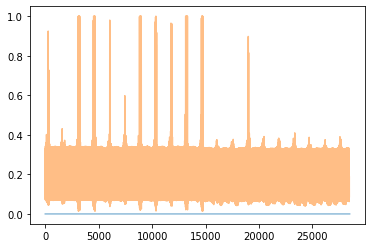

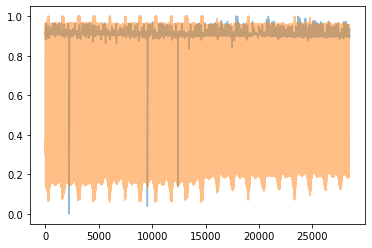

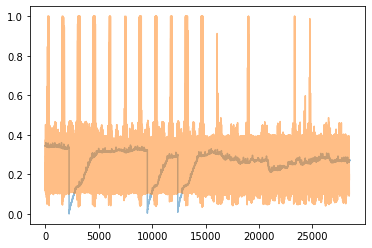

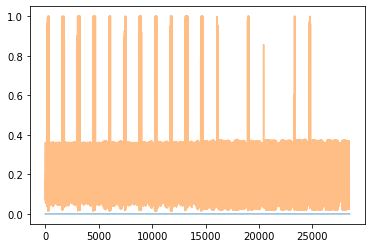

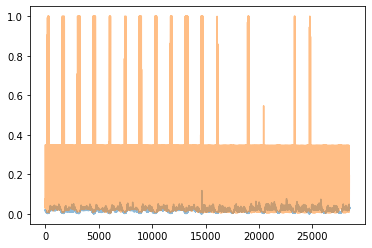

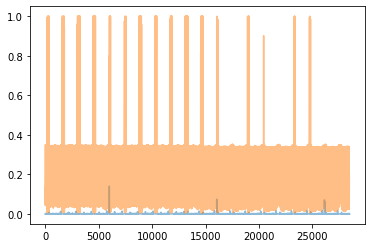

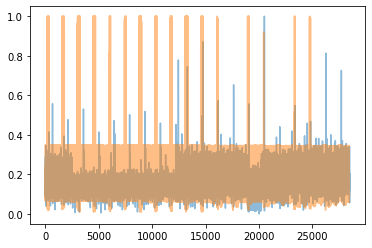

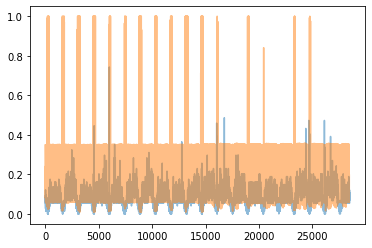

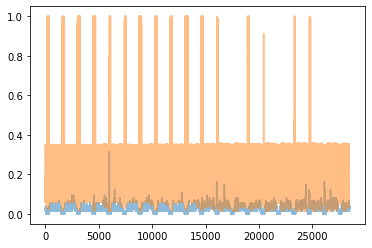

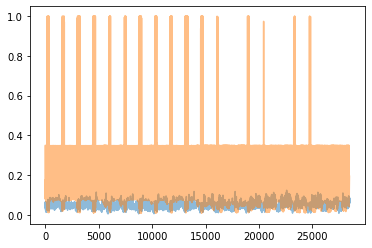

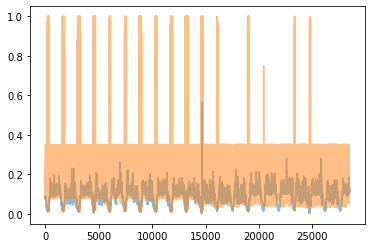

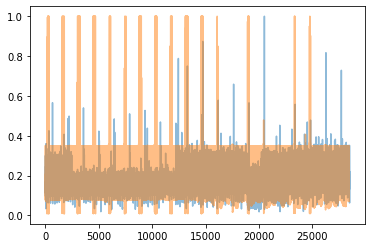

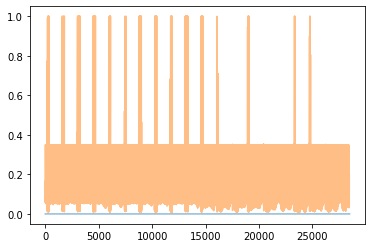

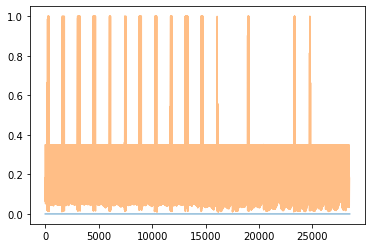

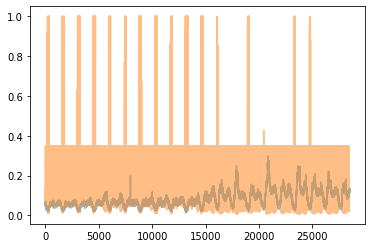

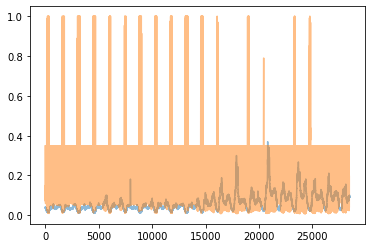

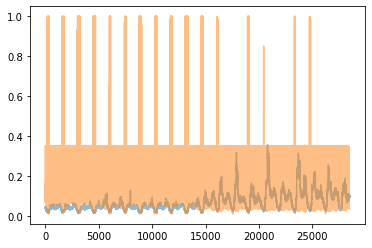

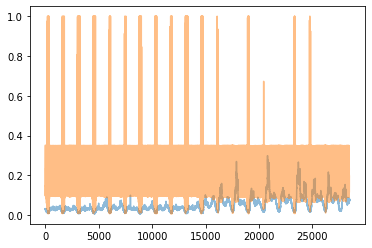

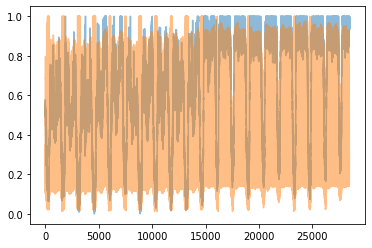

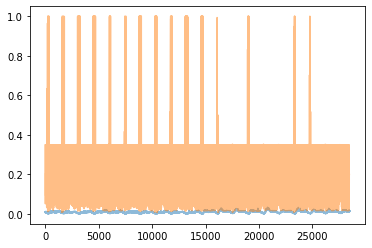

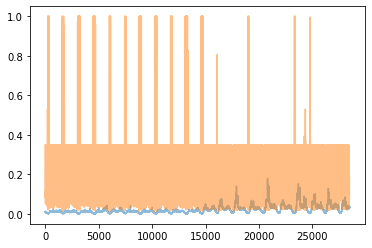

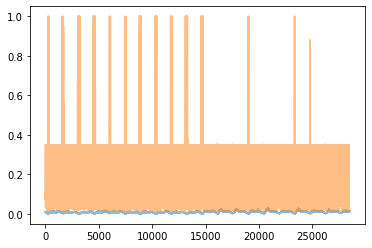

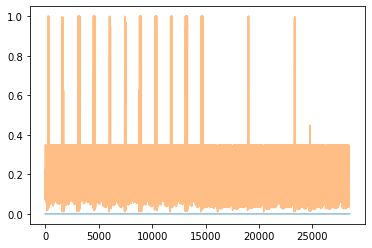

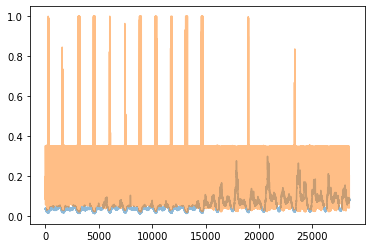

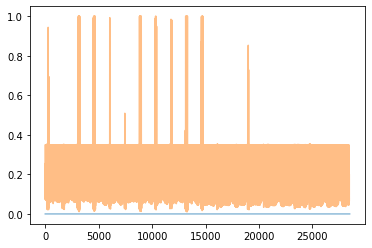

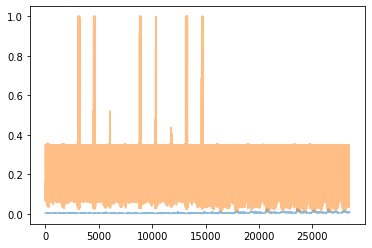

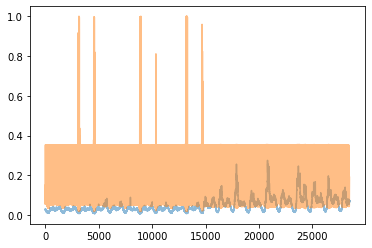

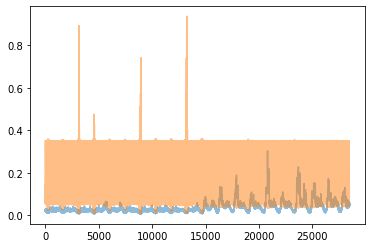

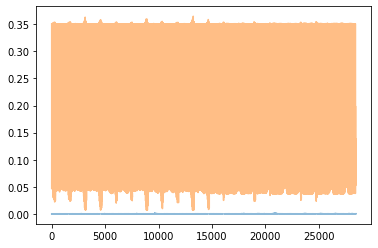

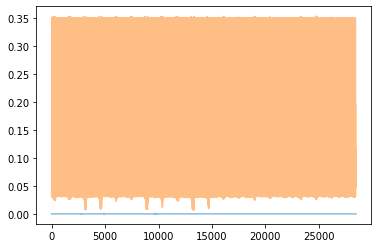

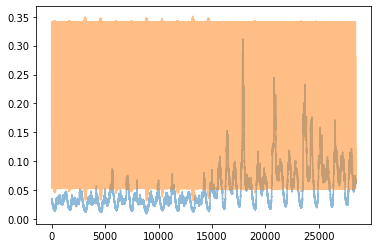

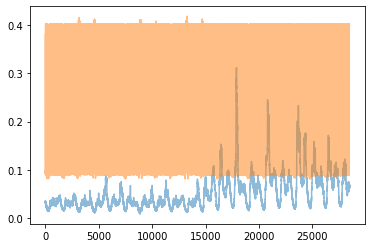

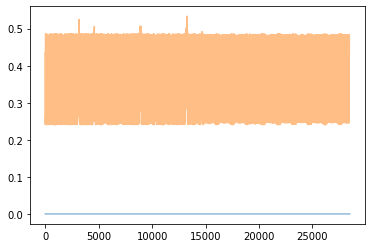

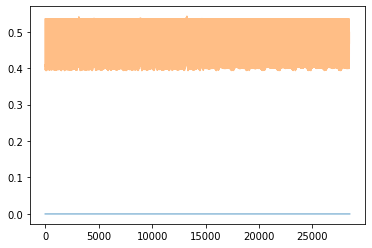

MSE : 0.0504


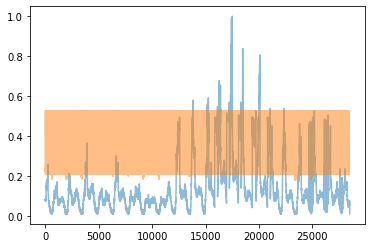

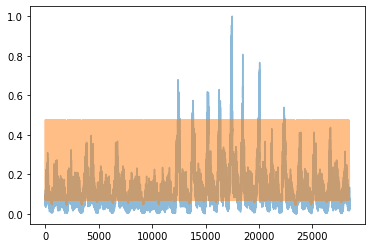

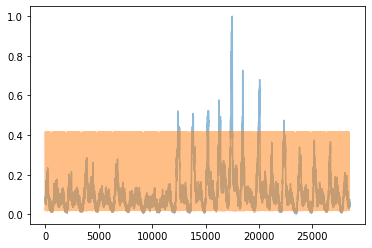

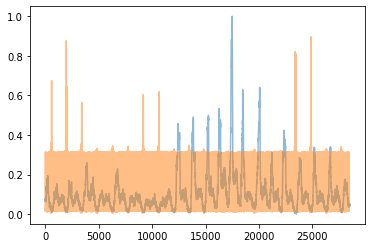

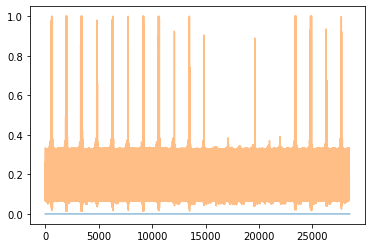

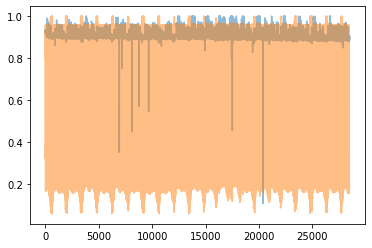

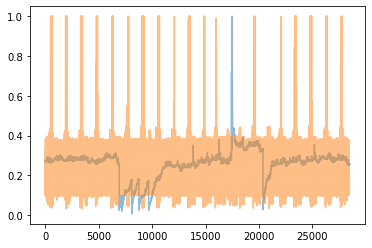

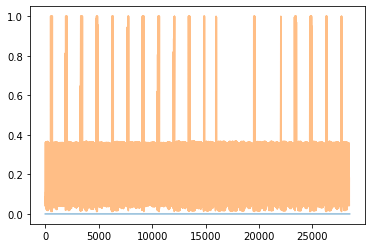

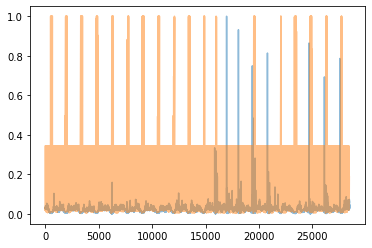

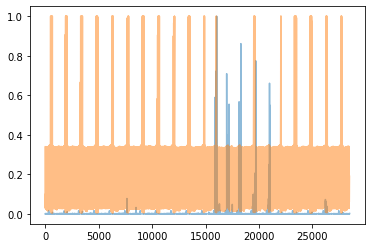

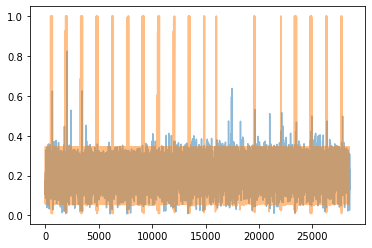

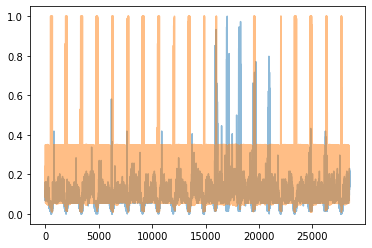

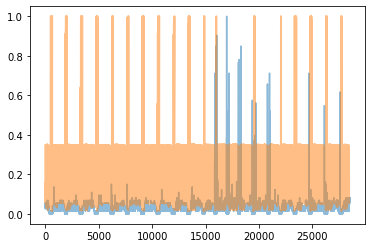

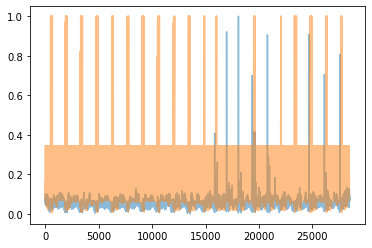

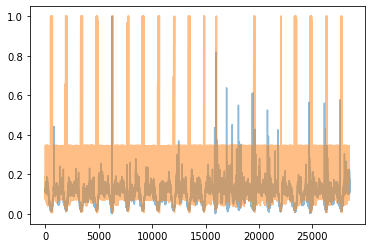

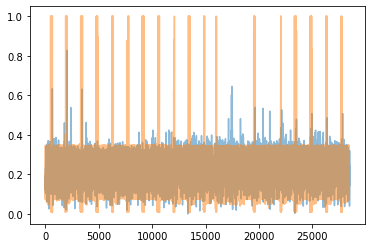

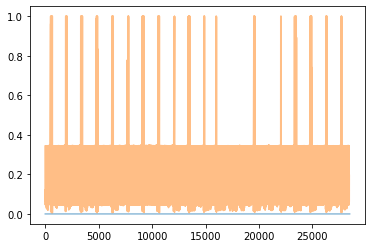

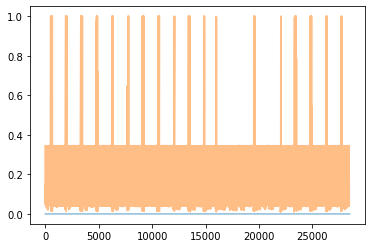

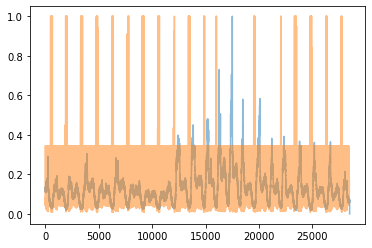

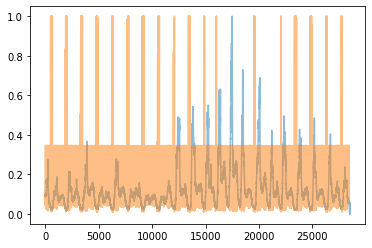

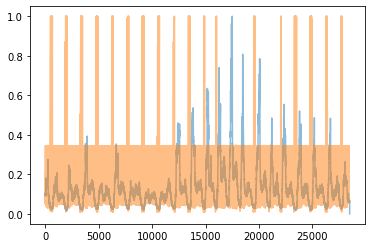

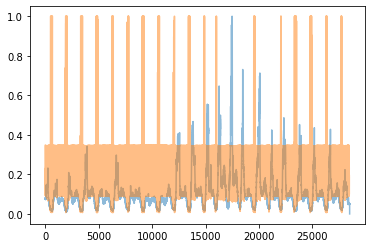

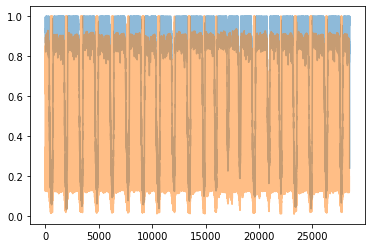

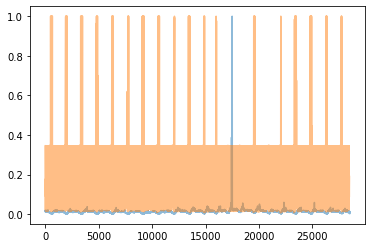

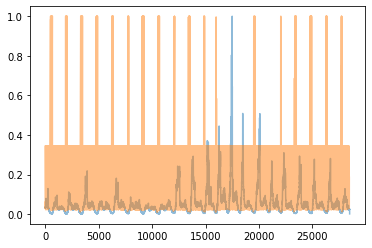

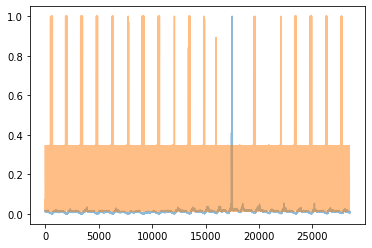

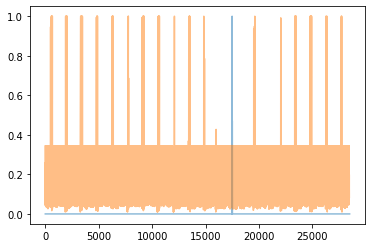

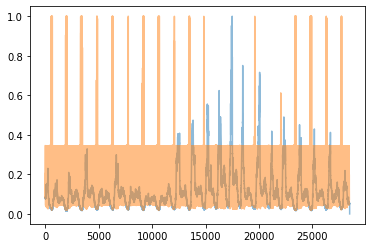

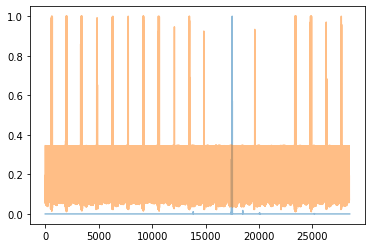

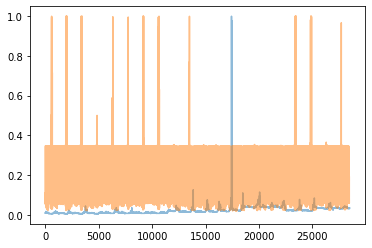

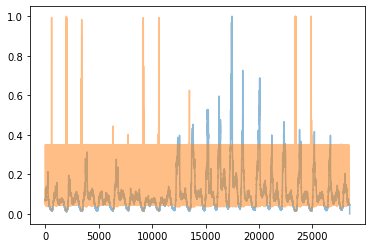

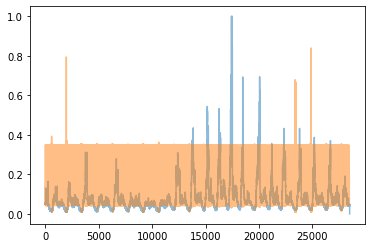

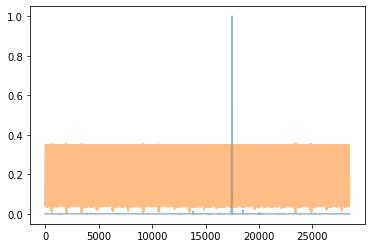

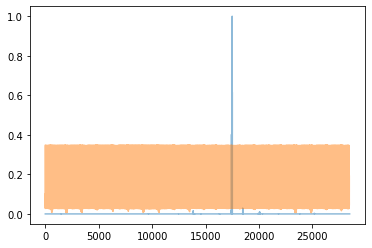

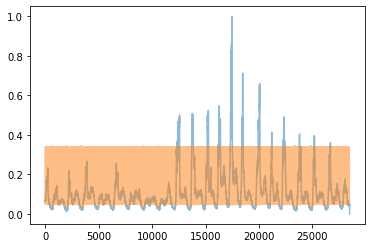

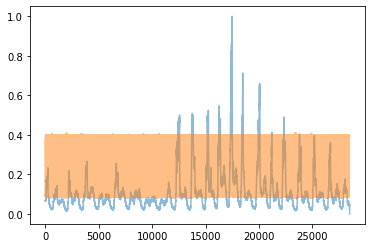

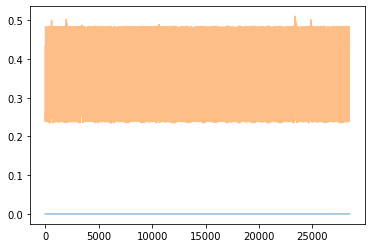

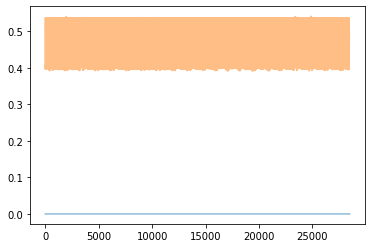

MSE : 0.05371


In [17]:
plot_train_test_reconstructions(model, X_train_tensor, X_train_data, X_test_tensor,X_test_data)

2021-01-25 12:12:25.910680
Computing AUPR for 27992 thresholds ... 


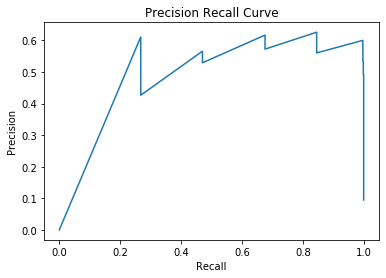


--- AUPR ---
0.4909168178497525
Best F1 score : 0.7490939503763591 at threshold : -0.5173933603100416 (1-percentile : 0.25090604962364094)
Corresponding best precision : 0.5997767857142857, best recall : 0.9974016332590943

--- Metrics ---
precision : 0.5610894941634241 recall : 0.2676317743132888 f1 : 0.3624026137220407


2021-01-25 12:16:49.623212


In [18]:
import datetime
print(datetime.datetime.now())
evaluation_utils.VAE_anomaly_detection(model, X_test_tensor, X_test_data, X_train_data, df_Y_test, .02)

print(datetime.datetime.now())